In [171]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import os


In [172]:
# Step 2: Load dataset
df = pd.read_csv('../data/togo-dapaong_qc.csv')

# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Dataset shape and summary
print("Dataset Shape:", df.shape)
print("\nSummary Statistics:")
print(df.describe())

# Missing values check
missing_vals = df.isna().sum()
missing_pct = (missing_vals / len(df)) * 100
print("\nMissing Values (>5%):")
print(missing_pct[missing_pct > 5])


Dataset Shape: (525600, 19)

Summary Statistics:
                           Timestamp            GHI            DNI  \
count                         525600  525600.000000  525600.000000   
mean   2022-04-25 12:00:30.000000768     230.555040     151.258469   
min              2021-10-25 00:01:00     -12.700000       0.000000   
25%              2022-01-24 06:00:45      -2.200000       0.000000   
50%              2022-04-25 12:00:30       2.100000       0.000000   
75%              2022-07-25 18:00:15     442.400000     246.400000   
max              2022-10-25 00:00:00    1424.000000    1004.500000   
std                              NaN     322.532347     250.956962   

                 DHI           ModA           ModB           Tamb  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      116.444352     226.144375     219.568588      27.751788   
min         0.000000       0.000000       0.000000      14.900000   
25%         0.000000       0.000000       0.

In [173]:
# Ensure 'Timestamp' is datetime type
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Step 3: Remove rows with negative values in key columns
key_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
df = df[(df[key_cols] >= 0).all(axis=1)]

# Step 4: Filter to keep only daytime hours (6 AM to 6 PM)
df = df[df['Timestamp'].dt.hour.between(6, 18)]

# Step 5: Compute Z-scores and flag outliers
z_scores = np.abs(stats.zscore(df[key_cols], nan_policy='omit'))
outlier_mask = (z_scores > 3)
outlier_rows = df.index[outlier_mask.any(axis=1)]
print("Number of rows flagged as outliers (|Z|>3):", len(outlier_rows))

# Optional: View a sample of the outliers
print(df.loc[outlier_rows].head())

# Step 6: Impute missing values in key columns using median
for col in key_cols:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

# Step 7: Drop outlier rows safely (ignore if some indices are missing)
cleaned_df = df.drop(index=outlier_rows, errors='ignore')
print("Cleaned DataFrame shape:", cleaned_df.shape)

# Step 8: Save cleaned data to file
os.makedirs('data', exist_ok=True)
cleaned_df.to_csv('data/benin_clean.csv', index=False)
print("Cleaned data exported to data/benin_clean.csv")


Number of rows flagged as outliers (|Z|>3): 1517
                Timestamp    GHI  DNI    DHI   ModA   ModB  Tamb    RH   WS  \
16808 2021-11-05 16:09:00   49.0  0.0   47.7   50.4   47.4  33.4  41.4  7.3   
16809 2021-11-05 16:10:00   50.5  0.0   49.1   51.7   48.7  33.3  41.8  8.2   
16855 2021-11-05 16:56:00   29.6  0.0   32.4   30.4   28.9  32.4  43.3  8.5   
16856 2021-11-05 16:57:00   28.6  0.0   31.3   29.3   27.8  32.3  44.5  7.8   
22561 2021-11-09 16:02:00  142.7  7.3  146.4  132.9  124.1  33.8  42.1  6.7   

       WSgust  WSstdev     WD  WDstdev   BP  Cleaning  Precipitation  TModA  \
16808     9.5      1.4  133.9     12.2  973         0            0.0   34.6   
16809    10.5      1.1  127.7     14.5  973         0            0.0   34.5   
16855    11.0      1.8  137.5     13.6  974         0            0.0   33.3   
16856    10.5      1.5  142.6     10.7  974         0            0.0   33.2   
22561    10.0      1.9   23.6     10.9  973         0            0.0   37.7   

 

In [174]:
# Step 4: Impute missing values in key columns using median
for col in key_cols:
    df[col] = df[col].fillna(df[col].median())


In [175]:
# Step 5: Remove outlier rows
cleaned_df = df.drop(index=outlier_rows)
print("Cleaned DataFrame shape:", cleaned_df.shape)


Cleaned DataFrame shape: (261165, 19)


In [176]:

# Step 6: Export cleaned data
os.makedirs('data', exist_ok=True)
cleaned_df.to_csv('../data/togo_clean.csv', index=False)
print("Cleaned data exported to data/sierraleone_clean.csv")


Cleaned data exported to data/sierraleone_clean.csv


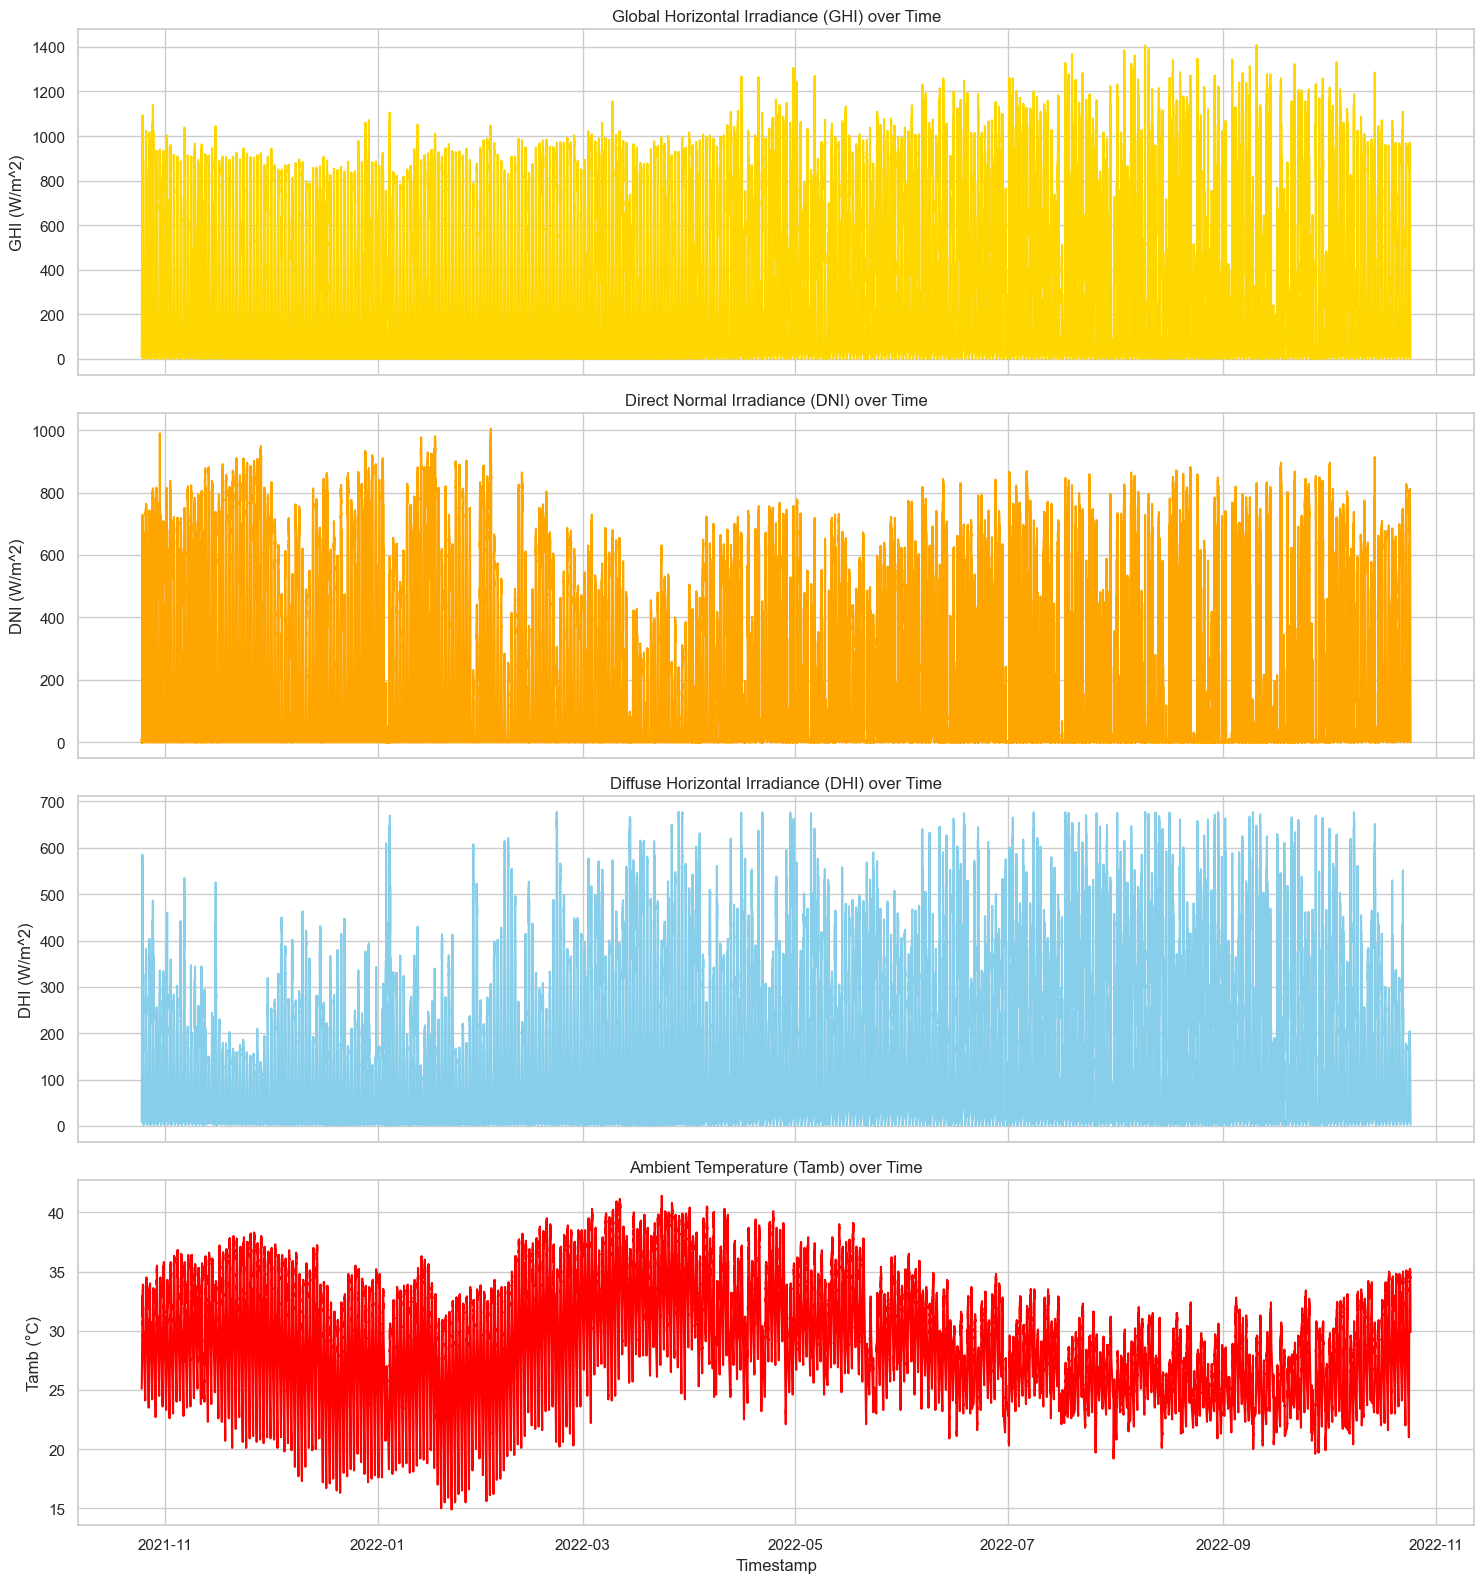

In [177]:
# Step 7: Time series visualization
cleaned_df = cleaned_df.sort_values('Timestamp')
fig, axs = plt.subplots(4, 1, figsize=(15, 16), sharex=True)

axs[0].plot(cleaned_df['Timestamp'], cleaned_df['GHI'], color='gold')
axs[0].set_ylabel('GHI (W/m^2)')
axs[0].set_title('Global Horizontal Irradiance (GHI) over Time')

axs[1].plot(cleaned_df['Timestamp'], cleaned_df['DNI'], color='orange')
axs[1].set_ylabel('DNI (W/m^2)')
axs[1].set_title('Direct Normal Irradiance (DNI) over Time')

axs[2].plot(cleaned_df['Timestamp'], cleaned_df['DHI'], color='skyblue')
axs[2].set_ylabel('DHI (W/m^2)')
axs[2].set_title('Diffuse Horizontal Irradiance (DHI) over Time')

axs[3].plot(cleaned_df['Timestamp'], cleaned_df['Tamb'], color='red')
axs[3].set_ylabel('Tamb (°C)')
axs[3].set_title('Ambient Temperature (Tamb) over Time')
axs[3].set_xlabel('Timestamp')

plt.tight_layout()
plt.show()


In [ ]:

axs[1].hist(cleaned_df['WS'], bins=50, color='skyblue', alpha=0.7)
axs[1].set_title('Distribution of Wind Speed')
axs[1].set_xlabel('Wind Speed (m/s)')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

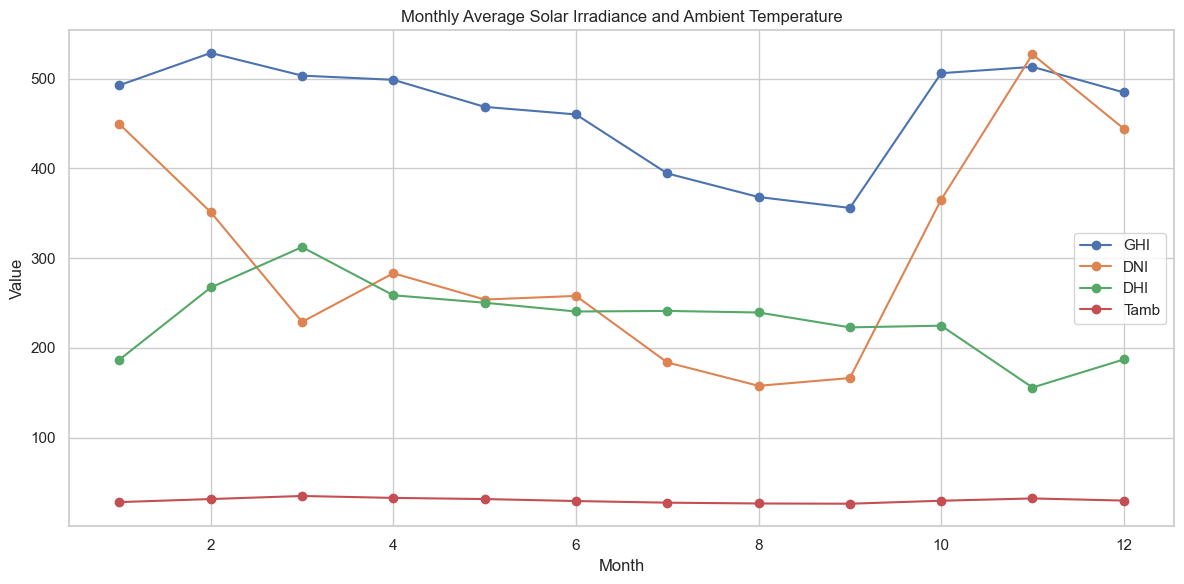

In [179]:


cleaned_df['Month'] = cleaned_df['Timestamp'].dt.month
monthly_avg = cleaned_df.groupby('Month')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

monthly_avg.plot(figsize=(12,6), marker='o')
plt.title('Monthly Average Solar Irradiance and Ambient Temperature')
plt.xlabel('Month')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()





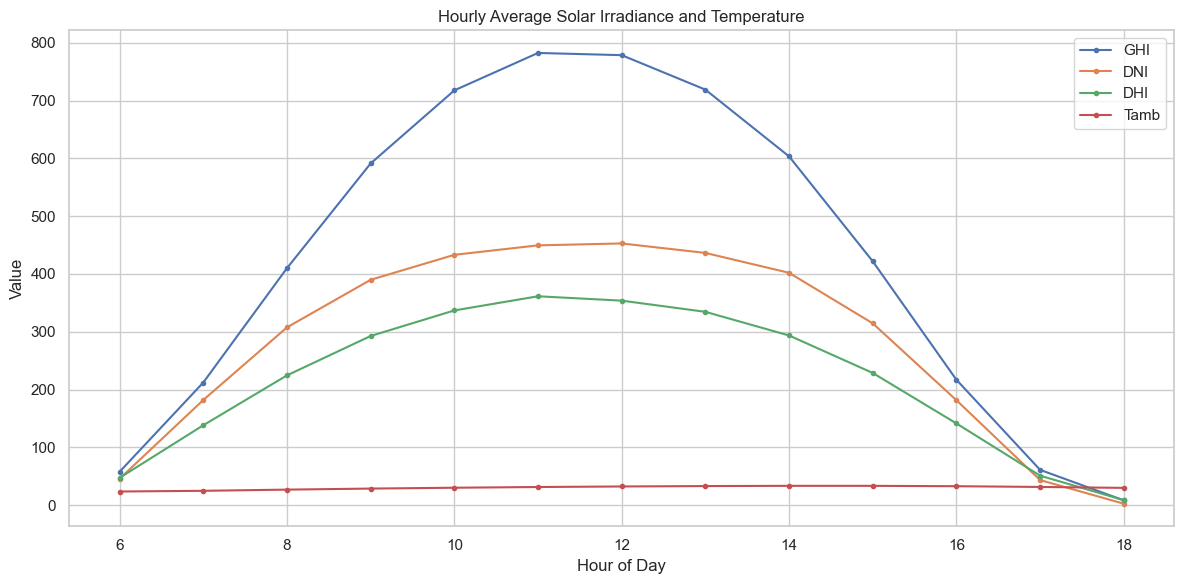

In [180]:
cleaned_df['Hour'] = cleaned_df['Timestamp'].dt.hour
hourly_avg = cleaned_df.groupby('Hour')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

hourly_avg.plot(figsize=(12,6), marker='.')
plt.title('Hourly Average Solar Irradiance and Temperature')
plt.xlabel('Hour of Day')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()


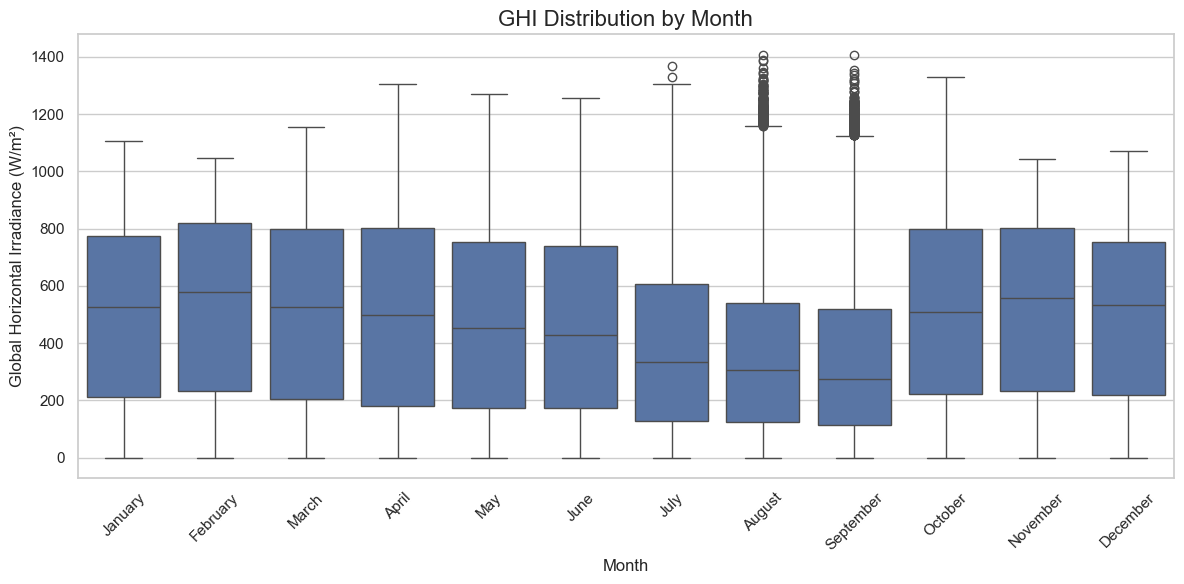

In [181]:

# Ensure 'Month' column exists
cleaned_df['Month'] = cleaned_df['Timestamp'].dt.month_name()

# Set Seaborn style
sns.set(style="whitegrid")

# Box plot: GHI distribution by Month
plt.figure(figsize=(12, 6))
sns.boxplot(data=cleaned_df, x='Month', y='GHI', order=[
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
])
plt.title('GHI Distribution by Month', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Global Horizontal Irradiance (W/m²)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




<Figure size 1200x600 with 0 Axes>

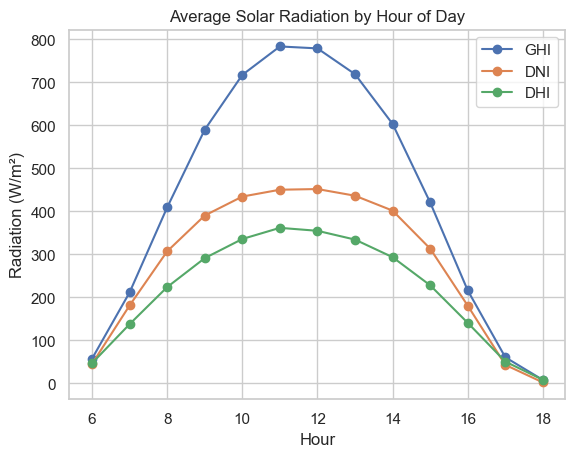

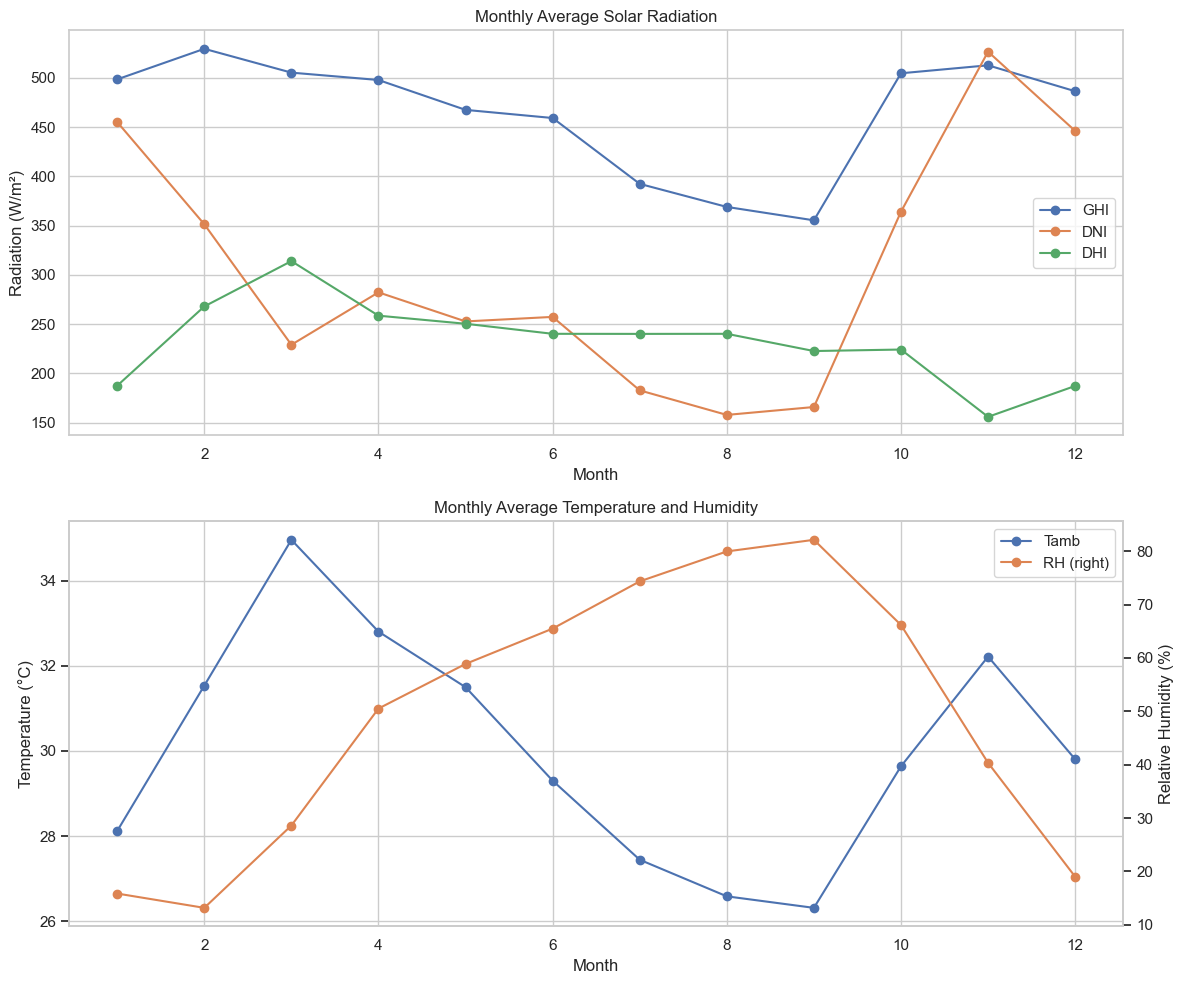

In [182]:
# Add hour and month columns for temporal analysis
df['Hour'] = df['Timestamp'].dt.hour
df['Month'] = df['Timestamp'].dt.month

# Calculate hourly averages for GHI, DNI, DHI
hourly_avg = df.groupby('Hour')[['GHI', 'DNI', 'DHI']].mean()

# Plot daily patterns
plt.figure(figsize=(12, 6))
hourly_avg.plot(marker='o')
plt.title('Average Solar Radiation by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Radiation (W/m²)')
plt.grid(True)
plt.show()

# Monthly patterns
monthly_avg = df.groupby('Month')[['GHI', 'DNI', 'DHI', 'Tamb', 'RH']].mean()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

monthly_avg[['GHI', 'DNI', 'DHI']].plot(ax=ax1, marker='o')
ax1.set_title('Monthly Average Solar Radiation')
ax1.set_xlabel('Month')
ax1.set_ylabel('Radiation (W/m²)')
ax1.grid(True)

monthly_avg[['Tamb', 'RH']].plot(ax=ax2, marker='o', secondary_y=['RH'])
ax2.set_title('Monthly Average Temperature and Humidity')
ax2.set_xlabel('Month')
ax2.set_ylabel('Temperature (°C)')
ax2.right_ax.set_ylabel('Relative Humidity (%)')
ax2.grid(True)

plt.tight_layout()
plt.show()

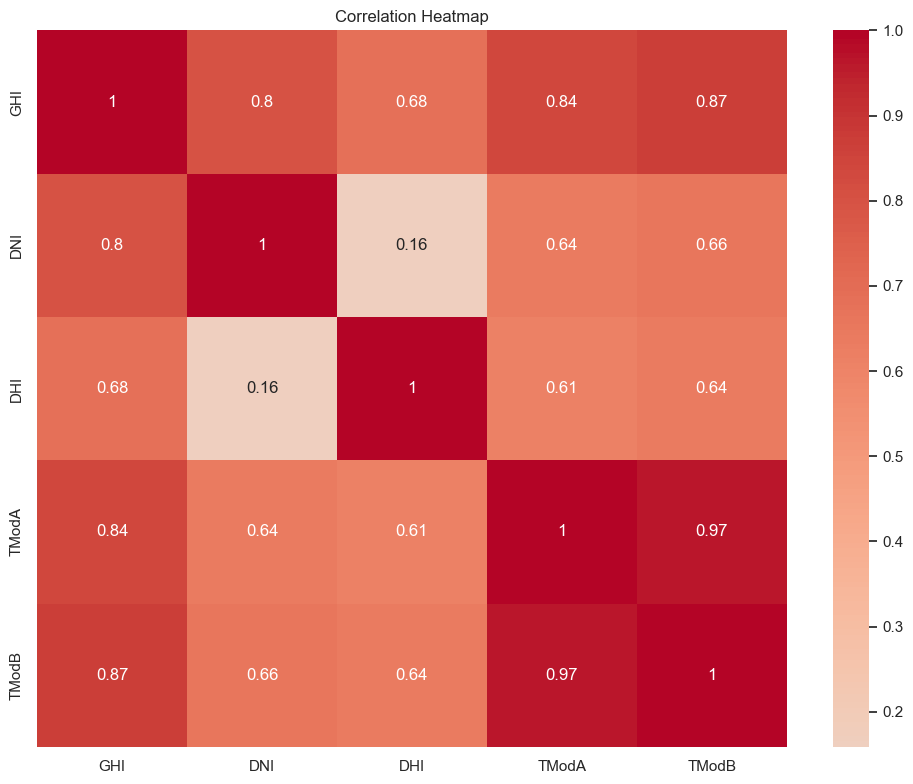

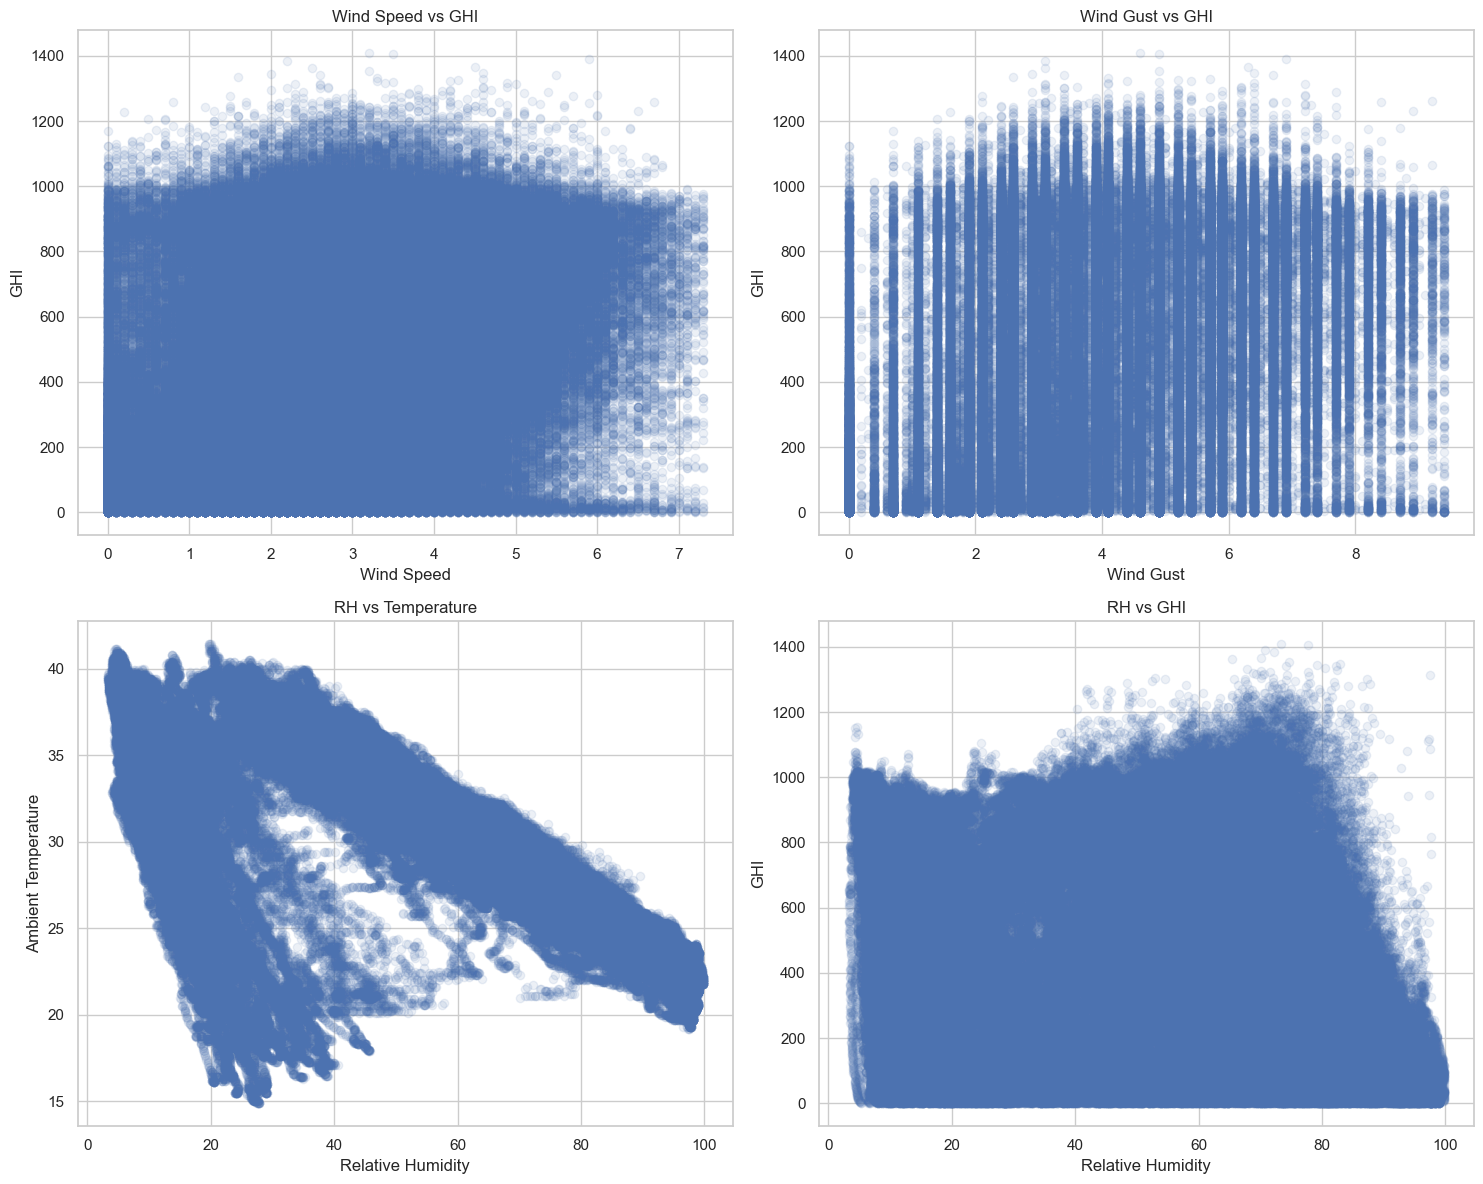

In [183]:

 #Correlation Analysis
corr_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
corr_matrix = cleaned_df[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# Scatter plots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

axs[0,0].scatter(cleaned_df['WS'], cleaned_df['GHI'], alpha=0.1)
axs[0,0].set_xlabel('Wind Speed')
axs[0,0].set_ylabel('GHI')
axs[0,0].set_title('Wind Speed vs GHI')

axs[0,1].scatter(cleaned_df['WSgust'], cleaned_df['GHI'], alpha=0.1)
axs[0,1].set_xlabel('Wind Gust')
axs[0,1].set_ylabel('GHI')
axs[0,1].set_title('Wind Gust vs GHI')

axs[1,0].scatter(cleaned_df['RH'], cleaned_df['Tamb'], alpha=0.1)
axs[1,0].set_xlabel('Relative Humidity')
axs[1,0].set_ylabel('Ambient Temperature')
axs[1,0].set_title('RH vs Temperature')

axs[1,1].scatter(cleaned_df['RH'], cleaned_df['GHI'], alpha=0.1)
axs[1,1].set_xlabel('Relative Humidity')
axs[1,1].set_ylabel('GHI')
axs[1,1].set_title('RH vs GHI')

plt.tight_layout()
plt.show()


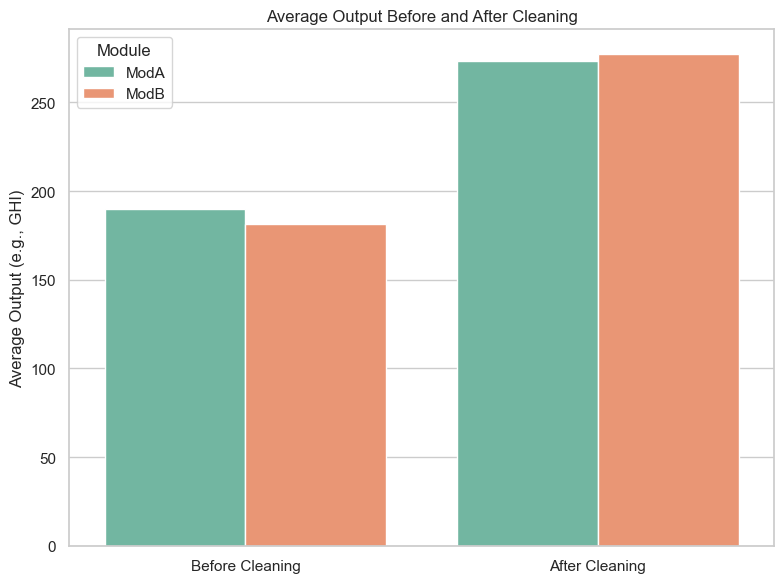

In [184]:

# Sample data: average output before and after cleaning
data = {
    'Cleaning Status': ['Before Cleaning', 'After Cleaning'],
    'ModA': [189.6807800708, 273.3092519685],
    'ModB': [181.5985212264, 277.2311023622]
}

# Create DataFrame
df = pd.DataFrame(data)

# Melt the DataFrame to long format for seaborn
df_melted = df.melt(id_vars='Cleaning Status', var_name='Module', value_name='Average Output')

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=df_melted, x='Cleaning Status', y='Average Output', hue='Module', palette='Set2')
plt.title('Average Output Before and After Cleaning')
plt.ylabel('Average Output (e.g., GHI)')
plt.xlabel('')
plt.tight_layout()
plt.show()

C:\Users\hlina\AppData\Local\Temp\ipykernel_19720\4100960828.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wind_rose = cleaned_df.groupby('WD_bin')['WS'].mean().reset_index()


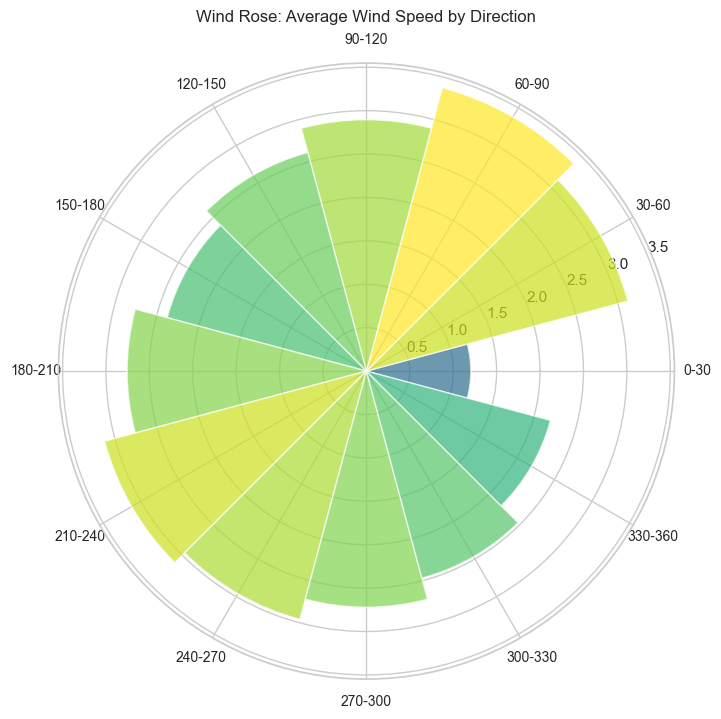

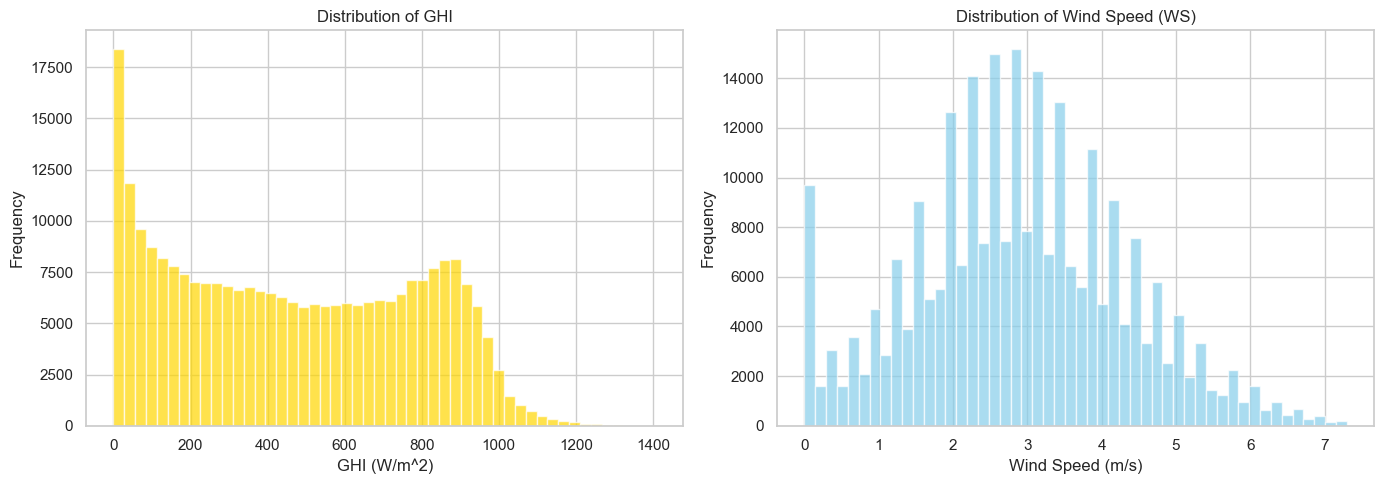

In [185]:
# Wind rose plot (radial bar) for WS/WD
import matplotlib.cm as cm
from math import pi

# Bin wind direction into 30-degree bins
wd_bins = np.arange(0, 361, 30)
wd_labels = [(str(wd_bins[i]) + '-' + str(wd_bins[i+1])) for i in range(len(wd_bins)-1)]
cleaned_df['WD_bin'] = pd.cut(cleaned_df['WD'], bins=wd_bins, labels=wd_labels, include_lowest=True)

# Average wind speed per direction bin
wind_rose = cleaned_df.groupby('WD_bin')['WS'].mean().reset_index()

# Radial bar plot
angles = np.linspace(0, 2 * np.pi, len(wind_rose), endpoint=False)
values = wind_rose['WS'].values
labels = wind_rose['WD_bin'].values

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, polar=True)
ax.bar(angles, values, width=2*np.pi/len(values), color=cm.viridis(values/np.max(values)), alpha=0.7)
ax.set_xticks(angles)
ax.set_xticklabels(labels, fontsize=10)
ax.set_title('Wind Rose: Average Wind Speed by Direction', va='bottom')
plt.show()

# Histograms for GHI and WS
fig, axs = plt.subplots(1, 2, figsize=(14,5))
axs[0].hist(cleaned_df['GHI'], bins=50, color='gold', alpha=0.7)
axs[0].set_title('Distribution of GHI')
axs[0].set_xlabel('GHI (W/m^2)')
axs[0].set_ylabel('Frequency')

axs[1].hist(cleaned_df['WS'], bins=50, color='skyblue', alpha=0.7)
axs[1].set_title('Distribution of Wind Speed (WS)')
axs[1].set_xlabel('Wind Speed (m/s)')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()